To group genes based on the temporal shape of their expression or accessibility changes, identifying shared dynamic patterns (e.g., early up, transient drop). This reveals coordinated response behaviors not apparent from magnitude alone, supporting second-generation ensemble analysis.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [27]:
# this cell runs this pipeline and saves the data for all chr.
# for individual analysis, see each cells below
# ---- Compute epsilon based on percentiles for "flat" behavior ----
def compute_epsilon(df, cols, percentile=20):
    d1 = df[cols[1]] - df[cols[0]]
    d2 = df[cols[2]] - df[cols[1]]
    epsilon = np.percentile(np.abs(np.concatenate([d1, d2])), percentile)
    return epsilon

# ---- Pattern classification based on direction of change ----
def interpret_pattern(y, epsilon):
    d1 = y[1] - y[0]
    d2 = y[2] - y[1]

    if abs(d1) < epsilon and abs(d2) < epsilon:
        return "flat"
    elif d1 > epsilon and d2 > epsilon:
        return "gradual up"
    elif d1 < -epsilon and d2 < -epsilon:
        return "gradual down"
    elif abs(d1) < epsilon and d2 > epsilon:
        return "late up"
    elif abs(d1) < epsilon and d2 < -epsilon:
        return "late down"
    elif d1 > epsilon and d2 < -epsilon:
        return "brief spike"
    elif d1 < -epsilon and d2 > epsilon:
        return "brief dip"
    else:
        return "complex/other"

def run_temporal_shape(df, cols, feat_label):
    epsilon = compute_epsilon(df, cols)
    # Z-score normalization
    data = df[cols].values
    z = StandardScaler().fit_transform(data)
    emb = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42).fit_transform(z)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
    clusters = clusterer.fit_predict(emb)

    df_ = df.copy()
    df_[f"{feat_label}_cluster"] = clusters

    # Compute cluster patterns
    cluster_avg = {}
    for c in sorted(set(clusters)):
        if c == -1: continue
        avg = df_[df_[f"{feat_label}_cluster"] == c][cols].mean().values
        cluster_avg[c] = avg

    # Interpret each cluster
    cluster_labels = {c: interpret_pattern(v, epsilon) for c, v in cluster_avg.items()}

    # Assign pattern label
    pattern_label_col = f"{feat_label}_pattern"
    def get_label(row):
        c = row[f"{feat_label}_cluster"]
        return cluster_labels.get(c, "noise")
    df_[pattern_label_col] = df_.apply(get_label, axis=1)

    return df_[['gene_name'] + cols + [pattern_label_col]]

def extract_temporal_value_trend(file_path):
    for chr_folder_name in os.listdir(file_path):
        chr_path = os.path.join(file_path, chr_folder_name)
        if not os.path.isdir(chr_path) or not chr_folder_name.startswith('chr'):
            continue

        df = pd.read_csv(f"{chr_path}/{chr_folder_name}_expr_acc_features.csv")
        
        expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
        acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
        all_cols = expr_cols + acc_cols
        
        df_filtered = df.dropna(subset=all_cols)
        print(f"{chr_folder_name}: Total genes: {len(df)}; Genes used: {len(df_filtered)}")

        # ---- Run for expression ----
        res_expr = run_temporal_shape(df_filtered, expr_cols, 'expression')
        
        # ---- Run for accessibility ----
        res_acc = run_temporal_shape(df_filtered, acc_cols, 'accessibility')

        # ---- Merge and construct combined pattern directly ----
        results = res_expr[['gene_name', 'expression_pattern']].merge(
            res_acc[['gene_name', 'accessibility_pattern']], on='gene_name'
        )
        results["combined_pattern"] = results["expression_pattern"] + " & " + results["accessibility_pattern"]

        results.to_csv(f"{chr_path}/{chr_folder_name}_temporal_value_patterns.csv", index=False)
        print(f"{chr_folder_name} data saved")

file_path = 'data/green_monkey/all_structure_files/'
extract_temporal_value_trend(file_path)


chr23: Total genes: 597; Genes used: 397


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr23 data saved
chr12: Total genes: 895; Genes used: 589


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr12 data saved
chr15: Total genes: 533; Genes used: 309


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr15 data saved
chr14: Total genes: 830; Genes used: 480


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr14 data saved
chr13: Total genes: 499; Genes used: 251


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr13 data saved
chr25: Total genes: 642; Genes used: 409


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr25 data saved
chr22: Total genes: 713; Genes used: 507


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr22 data saved
chr4: Total genes: 443; Genes used: 225


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr4 data saved
chr3: Total genes: 450; Genes used: 237


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr3 data saved
chr2: Total genes: 877; Genes used: 482


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr2 data saved
chr5: Total genes: 952; Genes used: 614


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr5 data saved
chr18: Total genes: 387; Genes used: 201


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


chr18 data saved
chr27: Total genes: 273; Genes used: 177


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr27 data saved
chr20: Total genes: 1596; Genes used: 1141


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr20 data saved
chr29: Total genes: 248; Genes used: 155


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


chr29 data saved
chr16: Total genes: 1415; Genes used: 960


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr16 data saved
chr10: Total genes: 772; Genes used: 479


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr10 data saved
chr28: Total genes: 291; Genes used: 218


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


chr28 data saved
chr21: Total genes: 839; Genes used: 517


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr21 data saved
chr19: Total genes: 577; Genes used: 432


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr19 data saved
chr26: Total genes: 580; Genes used: 383


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr26 data saved
chr7: Total genes: 573; Genes used: 321


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr7 data saved
chr6: Total genes: 1424; Genes used: 890


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was 

chr6 data saved
chr1: Total genes: 1323; Genes used: 802


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setti

chr1 data saved


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Total genes: 1323; Genes used: 802


/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


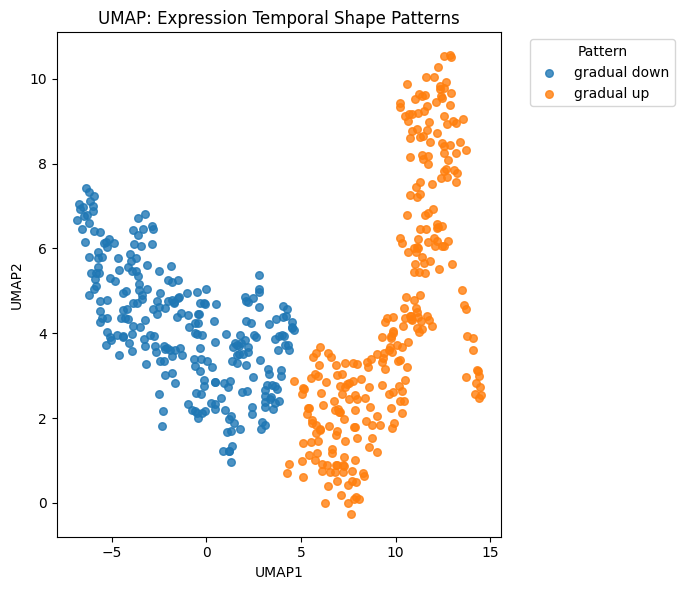

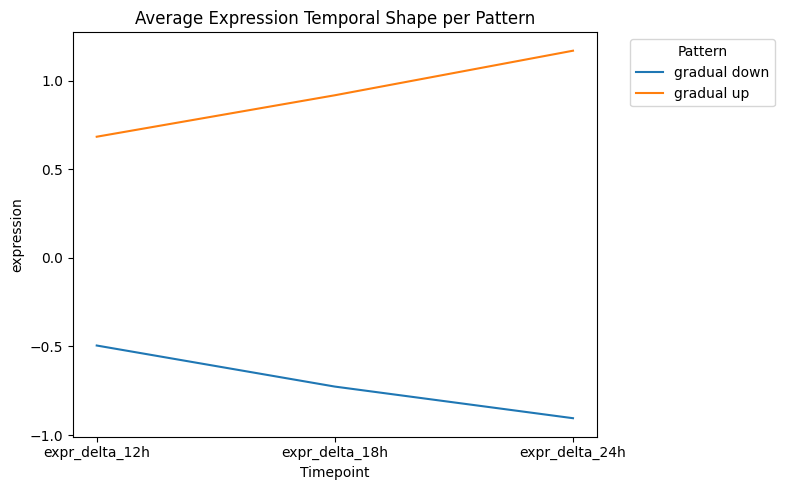

/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nafiulnipu/Desktop/RA_Projects/Genomic_Vis/GenomeVisProject/data_processing_python/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


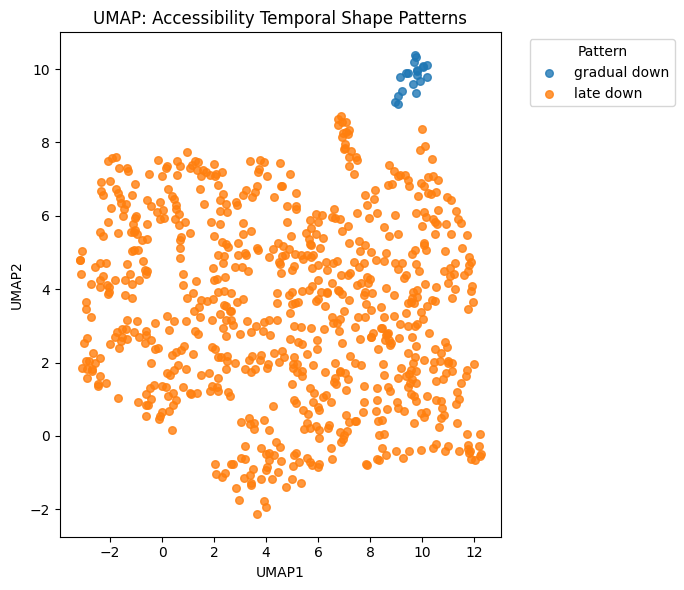

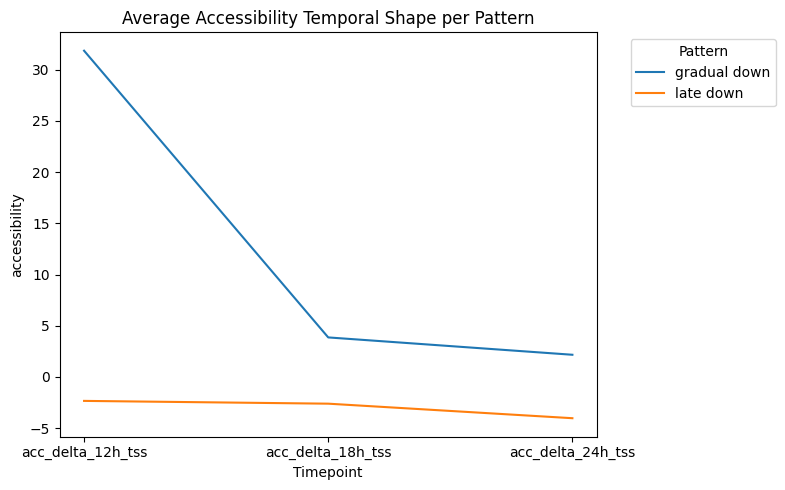

  gene_name expression_pattern accessibility_pattern          combined_pattern
0     BET1L       gradual down             late down  gradual down & late down
1     RIC8A       gradual down             late down  gradual down & late down
2     SIRT3       gradual down             late down  gradual down & late down
3    PSMD13       gradual down             late down  gradual down & late down
4     NLRP6         gradual up             late down    gradual up & late down


In [24]:
# ---- Load data ----
df = pd.read_csv("data/green_monkey/all_structure_files/chr1/chr1_expr_acc_features.csv")

expr_cols = ['expr_delta_12h', 'expr_delta_18h', 'expr_delta_24h']
acc_cols = ['acc_delta_12h_tss', 'acc_delta_18h_tss', 'acc_delta_24h_tss']
all_cols = expr_cols + acc_cols

df_filtered = df.dropna(subset=all_cols)
print(f"Total genes: {len(df)}; Genes used: {len(df_filtered)}")

# ---- Compute epsilon based on percentiles for "flat" behavior ----
def compute_epsilon(df, cols, percentile=20):
    d1 = df[cols[1]] - df[cols[0]]
    d2 = df[cols[2]] - df[cols[1]]
    epsilon = np.percentile(np.abs(np.concatenate([d1, d2])), percentile)
    return epsilon

# ---- Pattern classification based on direction of change ----
def interpret_pattern(y, epsilon):
    d1 = y[1] - y[0]
    d2 = y[2] - y[1]

    if abs(d1) < epsilon and abs(d2) < epsilon:
        return "flat"
    elif d1 > epsilon and d2 > epsilon:
        return "gradual up"
    elif d1 < -epsilon and d2 < -epsilon:
        return "gradual down"
    elif abs(d1) < epsilon and d2 > epsilon:
        return "late up"
    elif abs(d1) < epsilon and d2 < -epsilon:
        return "late down"
    elif d1 > epsilon and d2 < -epsilon:
        return "brief spike"
    elif d1 < -epsilon and d2 > epsilon:
        return "brief dip"
    else:
        return "complex/other"

def run_temporal_shape(df, cols, feat_label):
    epsilon = compute_epsilon(df, cols)
    
    # Z-score normalization
    data = df[cols].values
    z = StandardScaler().fit_transform(data)
    emb = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42).fit_transform(z)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
    clusters = clusterer.fit_predict(emb)

    df_ = df.copy()
    df_[f"{feat_label}_cluster"] = clusters

    # Compute cluster patterns
    cluster_avg = {}
    for c in sorted(set(clusters)):
        if c == -1: continue
        avg = df_[df_[f"{feat_label}_cluster"] == c][cols].mean().values
        cluster_avg[c] = avg

    # Interpret each cluster
    cluster_labels = {c: interpret_pattern(v, epsilon) for c, v in cluster_avg.items()}

    # Assign pattern label
    pattern_label_col = f"{feat_label}_pattern"
    def get_label(row):
        c = row[f"{feat_label}_cluster"]
        return cluster_labels.get(c, "noise")
    df_[pattern_label_col] = df_.apply(get_label, axis=1)

    # ---- UMAP scatter plot with pattern label colors ----
    palette = sns.color_palette("tab10", len(set(cluster_labels.values())))
    pat2color = {p: palette[i % len(palette)] for i, p in enumerate(sorted(set(cluster_labels.values())))}
    plt.figure(figsize=(7, 6))
    for pat in sorted(set(cluster_labels.values())):
        idx = df_[pattern_label_col] == pat
        plt.scatter(emb[idx, 0], emb[idx, 1], label=pat, color=pat2color[pat], alpha=0.8, s=30)
    plt.title(f"UMAP: {feat_label.capitalize()} Temporal Shape Patterns")
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # ---- Average time series per pattern label ----
    plt.figure(figsize=(8, 5))
    for pat in sorted(set(cluster_labels.values())):
        idx = df_[pattern_label_col] == pat
        avg = df_.loc[idx, cols].mean()
        plt.plot(cols, avg, label=pat)
    plt.title(f"Average {feat_label.capitalize()} Temporal Shape per Pattern")
    plt.xlabel("Timepoint")
    plt.ylabel(feat_label)
    plt.legend(title="Pattern", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return df_[['gene_name'] + cols + [pattern_label_col]]

# ---- Run for expression ----
res_expr = run_temporal_shape(df_filtered, expr_cols, 'expression')

# ---- Run for accessibility ----
res_acc = run_temporal_shape(df_filtered, acc_cols, 'accessibility')

# ---- Merge and directly assign combined pattern ----
results = res_expr[['gene_name', 'expression_pattern']].merge(
    res_acc[['gene_name', 'accessibility_pattern']], on='gene_name'
)
results["combined_pattern"] = results["expression_pattern"] + " & " + results["accessibility_pattern"]

# ---- Save ----
# results.to_csv("data/green_monkey/all_structure_files/chr1/chr1_temporal_shape_patterns_annotated.csv", index=False)
print(results.head())
